In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from tqdm import tqdm
import copy
from typing import Dict, List, Optional, Set, Tuple
import pandas as pd
import random

In [23]:
!pip3 install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 2.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: pip3 install --upgrade pip


In [13]:
facebook = np.genfromtxt("facebook_combined.txt", delimiter=' ',dtype=int)
tree =  nx.from_edgelist(facebook)

In [14]:
# The SI model from dataset
def simulate_one_round_SI(
    G: nx.Graph,
    node_compartments: Dict[str, Set[int]],
    beta: float,
    rng: np.random.RandomState = np.random.RandomState(0),
):
    if len(node_compartments["I"]) == 0 or len(node_compartments["S"]) == 0:
        return node_compartments
    s_to_i = []
    for node in node_compartments["I"]:
        for neighbor in set(G.neighbors(node)).intersection(node_compartments["S"]):
            if rng.rand() < beta:
                s_to_i.append(neighbor)
    for node in set(s_to_i):
        node_compartments["S"].remove(node)
        node_compartments["I"].add(node)
    return node_compartments


def simulate_t_steps_SI(
    G: nx.Graph,
    i_frac: float,
    beta: float,
    num_rounds: int,
    seed: Optional[int],
    full_output: bool = False,
) -> Dict[str, np.ndarray] | Tuple[
    Dict[str, np.ndarray], List[Set[int]], List[Set[int]]
]:
    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    num_nodes = G.number_of_nodes()
    i_num = int(i_frac * num_nodes)
    s_num = num_nodes - i_num
    nodes_perm = rng.permutation(G.nodes)
    node_compartments = {
        "S": set(nodes_perm[:s_num].tolist()),
        "I": set(nodes_perm[s_num:].tolist()),
    }
    s = [s_num]
    i = [i_num]
    if full_output:
        s_full = [copy.deepcopy(node_compartments["S"])]
        i_full = [copy.deepcopy(node_compartments["I"])]

    for _ in range(num_rounds):
        node_compartments = simulate_one_round_SI(G, node_compartments, beta, rng)
        if full_output:
            s_full.append(copy.deepcopy(node_compartments["S"]))
            i_full.append(copy.deepcopy(node_compartments["I"]))
        s.append(len(node_compartments["S"]))
        i.append(len(node_compartments["I"]))
    ans = {"S": np.array(s), "I": np.array(i)}
    if full_output:
        return ans, s_full, i_full
    return ans

In [15]:
#simulate 100 runs
s100=[]
i100=[]
ifull100 = []
for i in range(100):
    ans,s_full,i_full=simulate_t_steps_SI(G=tree,i_frac=4/tree.number_of_nodes(),beta=0.005,num_rounds=100,full_output=True,seed=None)
    s100.append(ans['S'])
    i100.append(ans['I'])
    ifull100.append(i_full)
si_out = pd.DataFrame({"t":list(range(0,101)),"S":[sum(x)/100 for x in zip(*s100)],"I":[sum(x)/100 for x in zip(*i100)]})


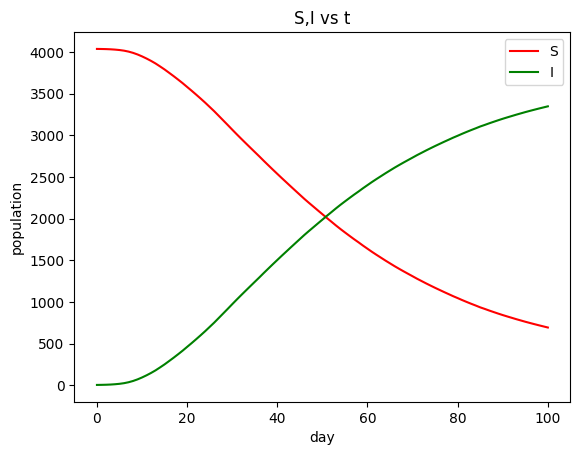

In [16]:
plt.plot('t','S', color='red', data=si_out)
plt.plot('t','I', color='green',data=si_out)
plt.title("S,I vs t")
plt.xlabel('day')
plt.ylabel('population')
legend=plt.legend()
plt.savefig('3.1.1.png')

In [17]:
# Convert the daily_infection num difference from day1 and day2 to write a list of new infection number per day.
daily_infection_num = []
for idx in range(100):
    temp = [4]
    for idx2 in range(1,len(ifull100[0])):
        temp.append(len(ifull100[idx][idx2])-len(ifull100[idx][idx2-1]))
    daily_infection_num.append(temp)
ifullaverage = pd.DataFrame({"t":list(range(0,101)),"newinfection":[sum(x)/100 for x in zip(*daily_infection_num)]})

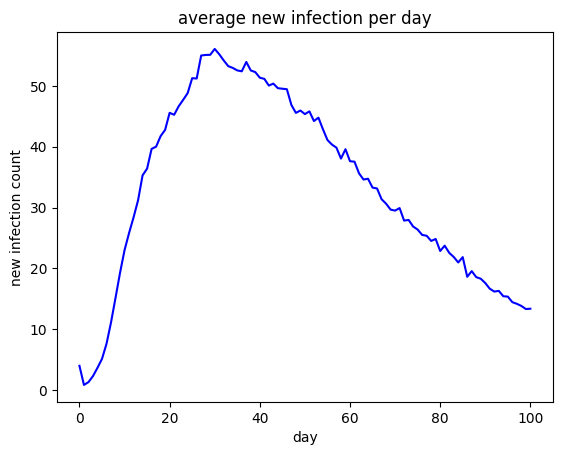

In [18]:
plt.plot('t','newinfection', color='blue', data=ifullaverage)
plt.title("average new infection per day")
plt.xlabel('day')
plt.ylabel('new infection count')
plt.savefig('3.1.2.png')

In [19]:
newinfection = np.array(ifullaverage['newinfection']).tolist()
tmax = newinfection.index(max(newinfection))
tmax

30

3.2

In [20]:
k = 100
nodes = np.load('rand_nodes.npy')
nodes = nodes.astype(int)
facebook = np.genfromtxt('facebook_combined.txt', delimiter=' ',dtype=int)
facebook_graph =  nx.from_edgelist(facebook)

In [21]:
facebookdic = {}
for node in facebook:
    if node[0] not in facebookdic:
        facebookdic[node[0]] = []
    if node[1] not in facebookdic:
        facebookdic[node[1]] = []
    facebookdic[node[0]].append(node[1])
    facebookdic[node[1]].append(node[0])

In [25]:
eigenvectordic = nx.eigenvector_centrality_numpy(facebook_graph)
eigenvectorlist = []
for key in eigenvectordic:
    eigenvectorlist.append([key,eigenvectordic[key]])
eigenvectorlist = sorted(eigenvectorlist, key=lambda x:x[1], reverse = True)

In [26]:
def Random(k,nodes):
    return nodes[0:k]

In [27]:
def Friends(random_nodes,facebookdic):
    friendlist = []
    for x in random_nodes:
        friendlist.append(random.choice(facebookdic[x]))
    return friendlist

In [28]:
def Central(k,eigenvectorlist):
    templist = []
    for row in eigenvectorlist[0:k]:
        templist.append(row[0])
    return templist

In [29]:
random_nodes = Random(k,nodes)
friend_nodes = Friends(random_nodes,facebookdic)
central_nodes = Central(k,eigenvectorlist)

In [30]:
ifull20 = []
for i in range(20):
    ans,s_full,i_full=simulate_t_steps_SI(G=tree,i_frac=4/tree.number_of_nodes(),beta=0.005,num_rounds=100,full_output=True,seed=None)
    ifull20.append(i_full)

In [31]:
def sensor_fraction(ifull20,interested_nodes,k):
    intersection_list = []
    for idx in range(20):
        temp = []
        for idx2 in range(len(ifull20[0])):
            # Find the intersection of two lists to see the fraction of sensors infected
            intersection = list(set(ifull20[idx][idx2]).intersection(interested_nodes))
            temp.append(len(intersection)/k)
        intersection_list.append(temp)
    ifullaverage = pd.DataFrame({"t":list(range(0,101)),"infected_fraction":[sum(x)/20 for x in zip(*intersection_list)]})
    return ifullaverage

In [32]:
random_fraction = sensor_fraction(ifull20,random_nodes,k)
friend_fraction = sensor_fraction(ifull20,friend_nodes,k)
central_fraction = sensor_fraction(ifull20,central_nodes,k)

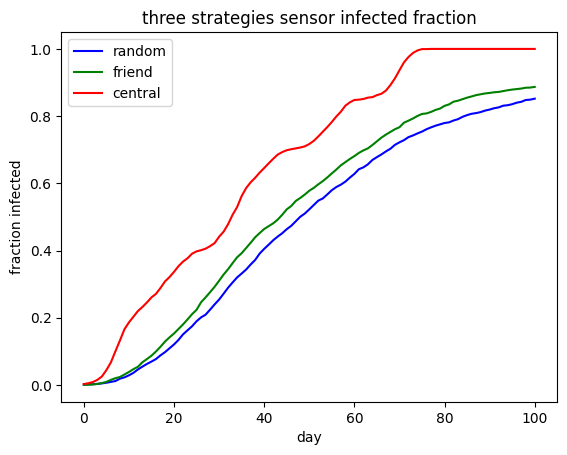

In [33]:
plt.plot('t','infected_fraction', color='blue', data=random_fraction)
plt.plot('t','infected_fraction', color='green', data=friend_fraction)
plt.plot('t','infected_fraction', color='red', data=central_fraction)
plt.title("three strategies sensor infected fraction")
plt.xlabel('day')
plt.ylabel('fraction infected')
mylabels = ['random','friend','central']
legend=plt.legend(labels=mylabels)
plt.savefig('3.2.1.png')

In [43]:
def daily_infection(dataframe):
    daily = []
    templist = list(dataframe['infected_fraction'])
    for i in range(1,101):
        daily.append(templist[i]-templist[i-1])
    return daily

In [44]:
random_daily = daily_infection(random_fraction)
friend_daily = daily_infection(friend_fraction)
central_daily = daily_infection(central_fraction)

[0.0005,
 0.0,
 0.001,
 0.0015000000000000005,
 0.002,
 0.0024999999999999988,
 0.0025000000000000005,
 0.007000000000000003,
 0.003999999999999997,
 0.006000000000000005,
 0.007499999999999993,
 0.010000000000000002,
 0.008500000000000008,
 0.008000000000000007,
 0.006999999999999992,
 0.007499999999999979,
 0.01100000000000001,
 0.009500000000000008,
 0.01150000000000001,
 0.011499999999999969,
 0.013499999999999998,
 0.016500000000000042,
 0.01200000000000001,
 0.011999999999999927,
 0.014999999999999986,
 0.011499999999999982,
 0.00800000000000009,
 0.015000000000000013,
 0.015499999999999958,
 0.014500000000000013,
 0.01749999999999996,
 0.018000000000000016,
 0.015499999999999958,
 0.015000000000000013,
 0.011500000000000066,
 0.011999999999999955,
 0.015000000000000069,
 0.013499999999999956,
 0.01899999999999996,
 0.014000000000000012,
 0.012500000000000122,
 0.0129999999999999,
 0.01100000000000001,
 0.009999999999999953,
 0.01200000000000001,
 0.010000000000000064,
 0.0134999

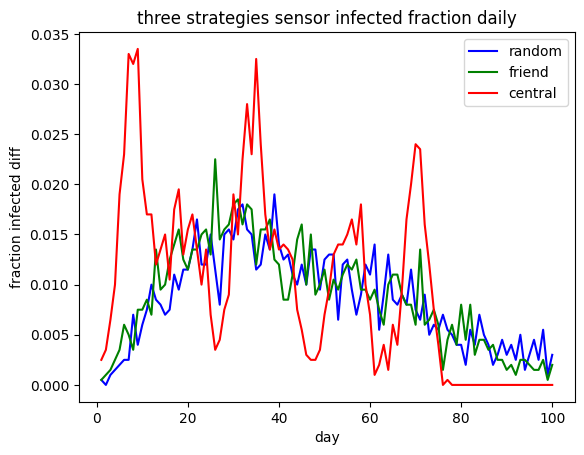

In [46]:
t = list(range(1,101))
plt.plot(t,random_daily, color='blue')
plt.plot(t,friend_daily, color='green')
plt.plot(t,central_daily, color='red')
plt.title("three strategies sensor infected fraction daily")
plt.xlabel('day')
plt.ylabel('fraction infected diff')
mylabels = ['random','friend','central']
legend=plt.legend(labels=mylabels)
plt.savefig('3.2.2.png')

3.3

In [47]:
def lead_time(dataset,daily):
    templist = list(dataset['infected_fraction'])
    return max(templist),max(daily),max(templist)-max(daily)

In [42]:
friend_daily

0.022499999999999964

In [48]:
random_peaktime, random_daily,random_leadtime=lead_time(random_fraction,random_daily)
friend_peaktime, friend_daily,friend_leadtime=lead_time(friend_fraction,friend_daily)
central_peaktime, central_daily,central_leadtime=lead_time(central_fraction,central_daily)
print("random peaktime:",random_peaktime, ' random peak daily infection:', random_daily, ' random lead time:',random_leadtime)
print("friend peaktime:",friend_peaktime, ' friend peak daily infection:', friend_daily, ' friend lead time:',friend_leadtime)
print("central peaktime:",central_peaktime, ' central peak daily infection:', central_daily, ' central lead time:',central_leadtime)

random peaktime: 0.8520000000000001  random peak daily infection: 0.01899999999999996  random lead time: 0.8330000000000002
friend peaktime: 0.8870000000000001  friend peak daily infection: 0.022499999999999964  friend lead time: 0.8645000000000002
central peaktime: 1.0  central peak daily infection: 0.0335  central lead time: 0.9665


3.4

The lead_time of random and friend are very similar, but central is way higher. Random and friend strategies basically rely on random choice of nodes. For central strategy, the nodes selected are under higher risk of infection, and thus choosing them as sensor and increase the lead time a lot, indicating the sensitivity of the strategy to discover outbreak.

3.5

In [26]:
k = 50
random_nodes = Random(k,nodes)
friend_nodes = Friends(random_nodes,facebookdic)
central_nodes = Central(k,eigenvectorlist)
random_fraction = sensor_fraction(ifull20,random_nodes,k)
friend_fraction = sensor_fraction(ifull20,friend_nodes,k)
central_fraction = sensor_fraction(ifull20,central_nodes,k)

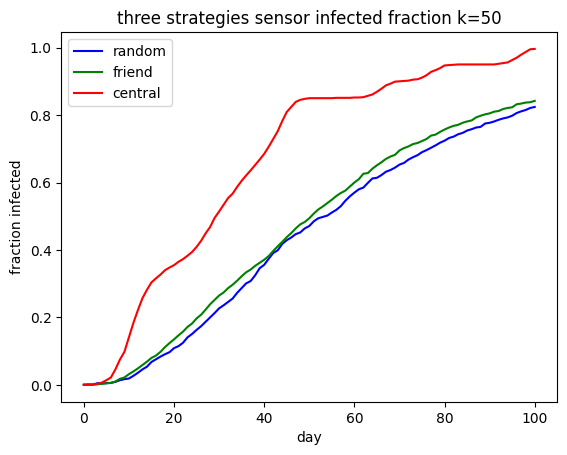

In [27]:
plt.plot('t','infected_fraction', color='blue', data=random_fraction)
plt.plot('t','infected_fraction', color='green', data=friend_fraction)
plt.plot('t','infected_fraction', color='red', data=central_fraction)
plt.title("three strategies sensor infected fraction k=50")
plt.xlabel('day')
plt.ylabel('fraction infected')
mylabels = ['random','friend','central']
legend=plt.legend(labels=mylabels)
plt.savefig('3.5.1.png')

In [28]:
random_leadtime=lead_time(random_fraction,random_daily)
friend_leadtime=lead_time(friend_fraction,friend_daily)
central_leadtime=lead_time(central_fraction,central_daily)
print("random",random_leadtime)
print("friend",friend_leadtime)
print("central",central_leadtime)

random 0.8045000000000001
friend 0.824
central 0.9500000000000002


In [29]:
k = 500
random_nodes = Random(k,nodes)
friend_nodes = Friends(random_nodes,facebookdic)
central_nodes = Central(k,eigenvectorlist)
random_fraction = sensor_fraction(ifull20,random_nodes,k)
friend_fraction = sensor_fraction(ifull20,friend_nodes,k)
central_fraction = sensor_fraction(ifull20,central_nodes,k)

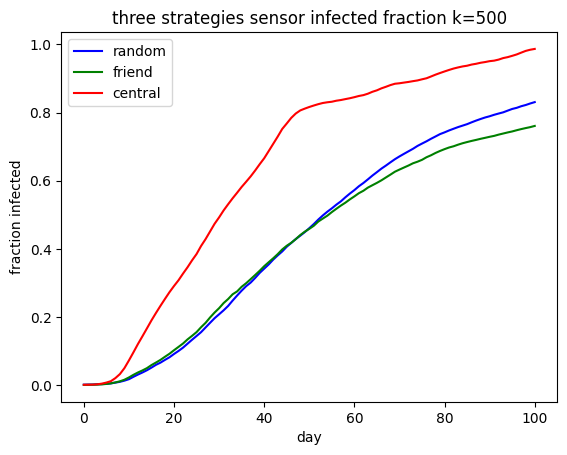

In [30]:
plt.plot('t','infected_fraction', color='blue', data=random_fraction)
plt.plot('t','infected_fraction', color='green', data=friend_fraction)
plt.plot('t','infected_fraction', color='red', data=central_fraction)
plt.title("three strategies sensor infected fraction k=500")
plt.xlabel('day')
plt.ylabel('fraction infected')
mylabels = ['random','friend','central']
legend=plt.legend(labels=mylabels)
plt.savefig('3.5.2.png')

In [31]:
random_leadtime=lead_time(random_fraction,random_daily)
friend_leadtime=lead_time(friend_fraction,friend_daily)
central_leadtime=lead_time(central_fraction,central_daily)
print("random",random_leadtime)
print("friend",friend_leadtime)
print("central",central_leadtime)

random 0.8109999999999999
friend 0.7425999999999999
central 0.9405999999999999


For random and friend strategy, they base on a random mechanism, so when k changes, the lead time can varies much, from 0.74 to 0.84 for friend and 0.80 to 0.84 for random strategy. Theoretically, friend should performe a little better than random because it somehow selectes the nodes with one degree of associate with other nodes. The difference is not obvious in different k values of the above graphs, but the friend curve at the most time is a little greater than random. For central, the strategy, due to its nature, is very robust and sensitive. No matter the k value, the lead time is around 0.95.